In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from Higgs.tools.ImplementationUtils import (
    implementChainDecayLimit,
    fromHB5Table1,
    readHEPDataCsv,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions
from scipy.interpolate import griddata
import root_numpy
import tempfile
import requests
import ROOT
import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution

BR_Z_ll = 2 * 3.3658e-2  # from 2020 PDG


Welcome to JupyROOT 6.24/06


# CMS 13TeV LHC

## `H>ZA > lltautau`  [1910.11634](https://arxiv.org/abs/1910.11634)

This analysis gives a usable acceptance ratio between ggH and bbH.

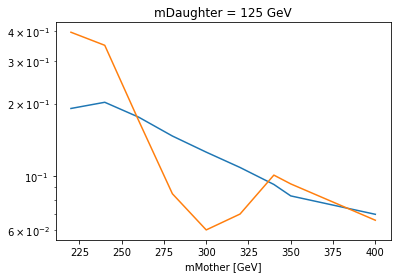

Looks good. Saving this to H_LHC13_CMS_36.json


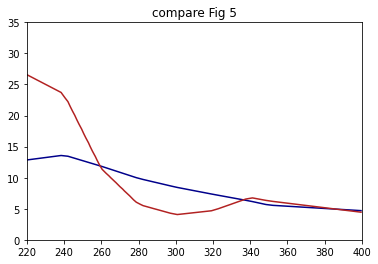

In [2]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1761088/Figure%205/1/csv"
)
df = dfs[0].rename(
    columns={
        "Mass of the A boson [GeV]": "mMother",
        "Cross section upper limit at 95% CL [fb]": "obs",
    }
)
df["exp"] = dfs[1]["Cross section upper limit at 95% CL [fb]"]
df["mDaughter"] = 125
df.obs *= 1e-3 / BR_Z_ll
df.exp *= 1e-3 / BR_Z_ll

limitFile = implementChainDecayLimit(
    "1910.11634",
    {"production": ["ggH", "bbH"], "chain": "Z", "decay": ["tautau"]},
    "https://doi.org/10.17182/hepdata.90685",
    df,
    massResolution={
        "daughter": {
            "absolute": 20,  # 90-180GeV m_tautau, so probably worse than this
            "relative": 0.0,
        },
        "mother": resolution.tautau["default"],
    },
    # the relative efficiency of bbH/ggH is given on page 14
    productionAcceptances=[{"constantAcceptance": 1}, {"constantAcceptance": 0.76}],
    prefix="H",
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("Z", "h1", 1.0)
h1.setDecayWidth("tautau", 1.0)
h1.setMass(125)
hm = np.linspace(220, 400)
r = np.linspace(0, 3.5e-2)

# use bbH with the non-trivial efficiency for the test
def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "bbH", rate / BR_Z_ll / 0.76)
    app = lim.apply(pred)
    if len(app) == 0:
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


fig, ax = plt.subplots()
test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
expCc = ax.contour(hm, 1e3 * r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, 1e3 * r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
ax.set_title("compare Fig 5")
plt.show()


# CMS 8TeV LHC

## `H>ZA > lltautau`  [1603.02991](https://arxiv.org/abs/1603.02991)

The data comes as a root histogram which needs some work.

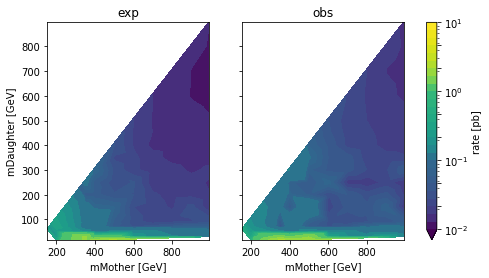

Looks good. Saving this to H_LHC8_CMS_20.json
[<Higgs.bounds.AppliedLimit limitId: 1603029911, obsRatio: 1.303, expRatio: 1.763, for: ["h1", ">", "h2"]>]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: Graph (Potential memory leak).


In [3]:
def trilGridFromHist(hist):
    fullRes, edges = root_numpy.hist2array(hist, return_edges=True)
    assert np.allclose(fullRes, fullRes.T)
    res = np.tril(fullRes)
    posArgs = np.nonzero(res > 0)
    i0 = np.min(posArgs[0])
    i0T = np.min(posArgs[1])
    iE = np.max(posArgs[0]) - len(res[0])
    iET = np.max(posArgs[1]) - len(res[1])
    x = np.convolve(edges[0][i0:iE], np.ones(2) / 2.0, mode="valid")
    y = np.convolve(edges[1][i0T:iET], np.ones(2) / 2.0, mode="valid")
    return (res[i0:iE, i0T:iET], x, y)


r = requests.get(
    "https://twiki.cern.ch/twiki/pub/CMSPublic/Hig15001TWiki/ExpLimitXStimesBR_lltautau_ShapeBased.C"
)
r.encoding = "utf-8"
with tempfile.NamedTemporaryFile(mode="w") as f:
    f.write(
        r.text.replace(
            r'TText *text = new TText(500,500,"Kinematically forbidden");',
            r'TText *text2 = new TText(500,500,"Kinematically forbidden");',
        )
    )
    ROOT.gROOT.LoadMacro(f.name)
exp, xExp, yExp = trilGridFromHist(ROOT.GRIDt2d)

r = requests.get(
    "https://twiki.cern.ch/twiki/pub/CMSPublic/Hig15001TWiki/ObsLimitXStimesBR_lltautau_ShapeBased.C"
)
r.encoding = "utf-8"
with tempfile.NamedTemporaryFile(mode="w") as f:
    f.write(
        r.text.replace(
            r'TText *text = new TText(500,500,"Kinematically forbidden");',
            r'TText *text2 = new TText(500,500,"Kinematically forbidden");',
        ).replace("GRIDt2d", "GRIDt2dobs")
    )
    ROOT.gROOT.LoadMacro(f.name)
obs, xObs, yObs = trilGridFromHist(ROOT.GRIDt2dobs)

assert np.allclose(xExp, xObs)
assert np.allclose(yExp, yObs)

exp = exp * 1e-3 / BR_Z_ll  # from fb to pb and correct for BR(Z>ll)
exp[exp == 0] = 1e6  # points where no limit is set
obs = obs * 1e-3 / BR_Z_ll  # from fb to pb and correct for BR(Z>ll)
obs[obs == 0] = 1e6  # points where no limit is set
# %%

XX, YY = np.meshgrid(xExp, yExp, indexing="ij")
df = pd.DataFrame(
    {
        "mMother": XX.flatten(order="C"),
        "mDaughter": YY.flatten(order="C"),
        "exp": exp.flatten(),
        "obs": obs.flatten(),
    }
)
limitFile = implementChainDecayLimit(
    "1603.02991",
    {
        "production": ["H"],
        "chain": "Z",
        "decay": ["tautau"],
    },
    "https://twiki.cern.ch/twiki/bin/view/CMSPublic/Hig15001TWiki",
    df,
    idSuffix=1,  # 2 is Zbb
    massResolution={
        "daughter": resolution.tautau["default"],  # from tautau
        "mother": resolution.tautau["default"],  # same abs at max mass
    },
    contourfPlotArgs={
        "levels": np.append(
            np.outer([1e-2, 0.1, 1.0], np.arange(1, 10, 1)).flatten(), 10
        ),
        "extend": "min",
        "norm": mcol.LogNorm(1e-2, 10),
    },
)

# no 1D limit to compare to, so just manually test some values
lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h1.setDecayWidth("Z", "h2", 1.0)
h2.setDecayWidth("tautau", 1.0)

h1.setMass(500)
h2.setMass(120)
h1.setCxn("LHC8", "ggH", 1e-2 / BR_Z_ll)

res = lim.apply(pred)
print(res)


## `A>Zh125>lltautau` [1510.01181](https://arxiv.org/abs/1510.01181)


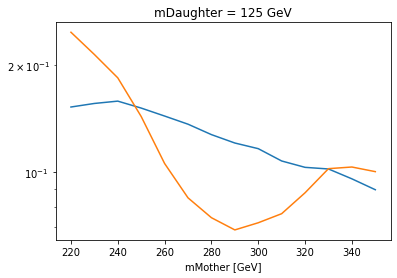

Looks good. Saving this to H_h125_LHC8_CMS_20.json


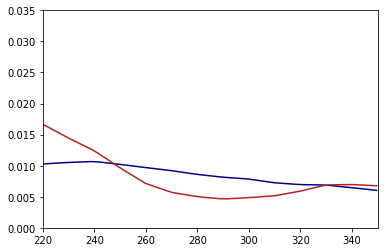

In [4]:
df = fromHB5Table1("140342_CMS_A-hZ-tautaull_19.7fb-1", "CMS").rename(
    columns={"m": "mMother"}
)
df["mDaughter"] = 125

df.obs *= 1e-3 / BR_Z_ll  # from fb to pb and correct for BR(Z>ll)
df.exp *= 1e-3 / BR_Z_ll  # from fb to pb and correct for BR(Z>ll)


limitFile = implementChainDecayLimit(
    "1510.01181",
    {"production": ["H"], "chain": "Z", "decay": ["tautau"]},
    "Fig. 10a",
    df,
    prefix="H_h125",
    massResolution={
        "daughter": {
            "absolute": 20,  # guess, may be a lot larger
            "relative": 0.0,
        },
        "mother": resolution.tautau["default"],
    },
    idSuffix=2, # 1 is HH>bbtautau
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("Z", "h1", 1.0)
h1.setDecayWidth("tautau", 1.0)
h1.setMass(125)
hm = np.linspace(220, 350)
r = np.linspace(0, 3.5e-2)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate/BR_Z_ll)
    app = lim.apply(pred)
    if len(app) == 0:
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
